In [95]:
# General Imports

import numpy as np
from PIL import Image
from astropy import nddata
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from jax.random import PRNGKey # Need to use a seed to start jax's random number generation

In [92]:
##############################################
# Acquiring Image, PSF, Variance ------------#
##############################################

# Opening Image
img = 'rsb_fits_images/test0.fits'

uncertainty_data = hdu[3].data    # variance
img_data = hdu[1].data            # image

psfex_hdu_data_index = 10
psfex_hdu_info_index = 9 
hdu = fits.open(img)

# Acquiring Workable PSF
psfex_info = hdu[psfex_hdu_info_index]
psfex_data = hdu[psfex_hdu_data_index]

pixstep = psfex_info.data._pixstep[0]  # Image pixel per PSF pixel
size = psfex_data.data["_size"]  # size of PSF  (nx, ny, n_basis_vectors)
comp = psfex_data.data["_comp"]  # PSF basis components
coeff = psfex_data.data["coeff"]  # Coefficients modifying each basis vector
psf_basis_image = comp[0].reshape(*size[0][::-1])
psf_image = psf_basis_image * psfex_data.data["basis"][0, :, np.newaxis, np.newaxis]
psf_image = psf_image.sum(0)
psf_image /= psf_image.sum() * pixstep**2

# Plotting PSF
# plt.imshow(psf_image, cmap='gray', interpolation='none',vmin=-0.0001, vmax=0.0001)
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.show()

# PLotting Retrieved FITS Image
# plt.imshow(img_data.data, vmin=0, vmax=0.3,origin="lower", cmap="gray")
# plt.title('Original Image Array')
# plt.show()

In [6]:
def gen_mask(image_shape):
    import jax.numpy as jnp
    return jnp.array(np.zeros(image_shape))

def gen_psf(image_shape):
    psf = np.zeros(image_shape)
    center = (image_shape[0] // 2, image_shape[1] // 2)
    psf[center] = 1
    sigma = 2  
    psf = gaussian_filter(psf, sigma=sigma)
    psf /= psf.sum()
    return psf

def resize_psf(psf_image, new_shape):
    import cv2
    resized_psf = cv2.resize(psf_image, new_shape, interpolation=cv2.INTER_AREA)
    resized_psf /= np.sum(resized_psf)    
    return resized_psf

In [91]:
##############################################
# Identifying Sources & Creating Cutouts ----#
##############################################

# Defining Threshold in Relation to Background RMS (how bright a source must be)
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(img_data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = 1.9 * bkg.background_rms 


from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(img_data, kernel)


# Detecting Sources --> Segmentation Map
from photutils.segmentation import detect_sources
from matplotlib.colors import LogNorm
segment_map = detect_sources(convolved_data, threshold, npixels=10)


segment_map.remove_border_labels(10, partial_overlap=False, relabel=False)
bbox = segment_map.bbox
shortened_bbox = bbox[10:len(bbox):30]

# Creating Same-Dimension Cutouts of Image, Mask, and Variance
cutouts = []
for i in range(len(shortened_bbox)):
    y_center, x_center = shortened_bbox[i].center
    x_len,y_len = shortened_bbox[i].shape
    min_length = 12 #22
    if (x_len> 10 and y_len > 10 and x_len < 40 and y_len < 40):
        length = max([x_len, y_len, min_length]) * 1.25
        my_cutout = nddata.Cutout2D(img_data, (x_center,y_center), int(length))
        cutout_mask = gen_mask(my_cutout.shape)
        # generated_psf = gen_psf(my_cutout.shape)
        # normalized_psf = generated_psf/np.sum(generated_psf)
        actual_psf = resize_psf(psf_image, my_cutout.shape)
        cutout_var = nddata.Cutout2D(uncertainty_data, (x_center,y_center), int(length))
        package = [my_cutout, cutout_mask, cutout_var, actual_psf] #normalized_psf,actual_psf]
        cutouts.append(package)

In [96]:
print(len(cutouts))

63


  3%|▎         | 322/10000 [00:00<00:03, 2709.87it/s, Round = 2,step_size = 1.0e-04 loss: 9.364e+04]


L1 norm: 0.05245577667305529
This model is a good fit.0.999999975732271


  3%|▎         | 259/10000 [00:00<00:03, 2729.10it/s, Round = 2,step_size = 1.0e-04 loss: 6.994e+04]


L1 norm: 0.04671981707722151
This model is a good fit.0.9999983975884386


  3%|▎         | 298/10000 [00:00<00:03, 2668.55it/s, Round = 2,step_size = 1.0e-04 loss: 1.809e+05]


L1 norm: 0.07957198992878402
This model is a good fit.1.0


  3%|▎         | 257/10000 [00:00<00:03, 2973.60it/s, Round = 2,step_size = 1.0e-04 loss: 5.507e+04]


L1 norm: 0.0500489929575979
This model is not good.8.95133049322593e-31


  3%|▎         | 251/10000 [00:00<00:01, 5438.65it/s, Round = 2,step_size = 1.0e-04 loss: 3.178e+04]


L1 norm: 0.04285970899793837
This model is a good fit.0.9999999999989313


  5%|▍         | 499/10000 [00:00<00:02, 3420.52it/s, Round = 2,step_size = 1.0e-04 loss: 3.302e+04]


L1 norm: 0.041994161903858185
This model is a good fit.0.9999999989017537


  3%|▎         | 264/10000 [00:00<00:04, 2383.36it/s, Round = 2,step_size = 1.0e-04 loss: 1.031e+06]


L1 norm: 0.06911608637595663
This model is not good.0.000614987994544979


  3%|▎         | 251/10000 [00:00<00:03, 2588.37it/s, Round = 2,step_size = 1.0e-04 loss: 7.244e+04]


L1 norm: 0.045658852443222174
This model is a good fit.0.9999999928254771


 12%|█▏        | 1240/10000 [00:00<00:01, 5144.58it/s, Round = 2,step_size = 1.0e-04 loss: 3.609e+04]


L1 norm: 0.04691614786783854
This model is a good fit.0.9992741693608513


  3%|▎         | 289/10000 [00:00<00:04, 2394.51it/s, Round = 2,step_size = 1.0e-04 loss: 9.455e+04]


L1 norm: 0.047243417548772745
This model is a good fit.0.9999999999999977


  3%|▎         | 251/10000 [00:00<00:02, 3258.97it/s, Round = 2,step_size = 1.0e-04 loss: 5.943e+04]


L1 norm: 0.050861662234402034
This model is a good fit.0.9993960868996333


  8%|▊         | 834/10000 [00:00<00:01, 4785.36it/s, Round = 2,step_size = 1.0e-04 loss: 3.723e+04]


L1 norm: 0.04704052395290799
This model is a good fit.0.9998499777225421


  3%|▎         | 282/10000 [00:00<00:03, 2852.75it/s, Round = 2,step_size = 1.0e-04 loss: 4.943e+05]


L1 norm: 0.06437692213102258
This model is not good.1.0843737023818953e-69


 21%|██        | 2074/10000 [00:00<00:02, 2969.84it/s, Round = 2,step_size = 1.0e-04 loss: 4.354e+04]


L1 norm: 0.040792641816315825
This model is a good fit.1.0


100%|██████████| 10000/10000 [00:01<00:00, 5217.89it/s, Round = 2,step_size = 1.0e-04 loss: 3.134e+04]


L1 norm: 0.046540501912434896
This model is a good fit.0.999976747739661


  4%|▍         | 417/10000 [00:00<00:04, 2195.02it/s, Round = 2,step_size = 1.0e-04 loss: 1.237e+05]


L1 norm: 0.04313074812597158
This model is not good.0.0


  3%|▎         | 251/10000 [00:00<00:03, 2685.02it/s, Round = 2,step_size = 1.0e-04 loss: 6.650e+04]


L1 norm: 0.04878768142388792
This model is a good fit.0.4096283450699178


  3%|▎         | 251/10000 [00:00<00:03, 2450.70it/s, Round = 2,step_size = 1.0e-04 loss: 1.072e+05]


L1 norm: 0.04843187255859375
This model is a good fit.0.9877352323969679


  3%|▎         | 259/10000 [00:00<00:01, 5390.31it/s, Round = 2,step_size = 1.0e-04 loss: 3.317e+04]


L1 norm: 0.043148138258192276
This model is a good fit.0.9999999965276593


  3%|▎         | 253/10000 [00:00<00:03, 2494.27it/s, Round = 2,step_size = 1.0e-04 loss: 3.712e+05]
/home/smjanson/.local/lib/python3.10/site-packages/pysersic/results.py:529: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,3,figsize=(13,3))


L1 norm: 0.05756855244539222
This model is not good.1.6740282776432134e-143


  4%|▍         | 388/10000 [00:00<00:03, 2454.48it/s, Round = 2,step_size = 1.0e-04 loss: 9.545e+04]


L1 norm: 0.05185730110269413
This model is a good fit.1.0


  3%|▎         | 251/10000 [00:00<00:05, 1758.66it/s, Round = 2,step_size = 1.0e-04 loss: 1.124e+06]


L1 norm: 0.0638763361714736
This model is a good fit.0.9997179141725588


  3%|▎         | 333/10000 [00:00<00:05, 1888.24it/s, Round = 2,step_size = 1.0e-04 loss: 2.760e+05]


L1 norm: 0.04542595134570755
This model is a good fit.1.0


100%|██████████| 10000/10000 [00:01<00:00, 5438.13it/s, Round = 2,step_size = 1.0e-04 loss: 3.205e+04]


L1 norm: 0.04545671251085069
This model is not good.5.5675847430614625e-06


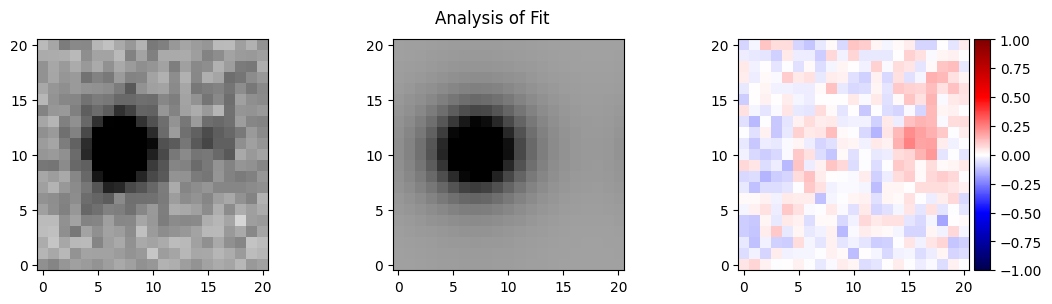

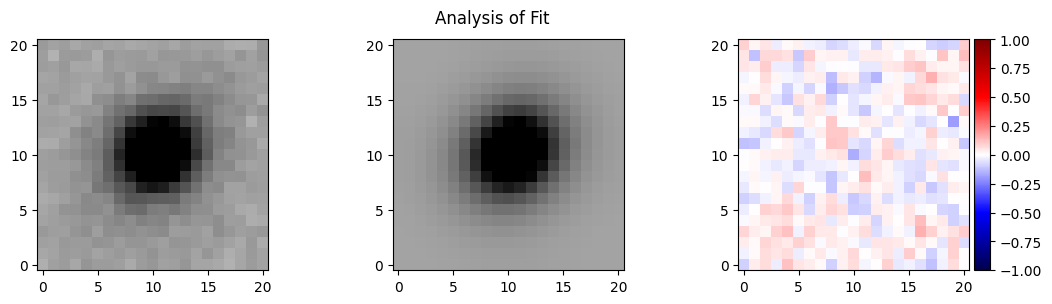

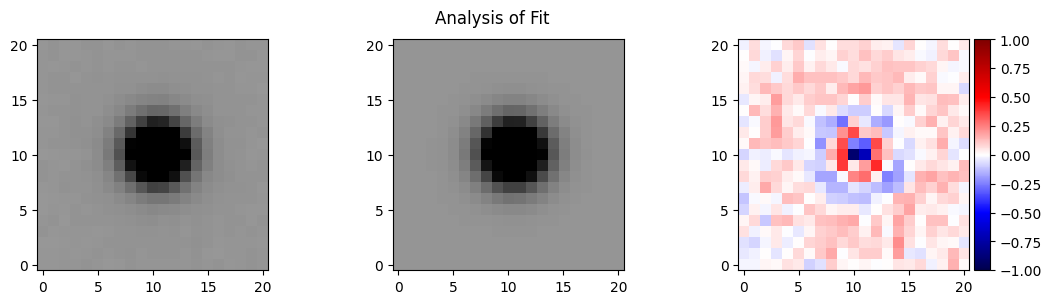

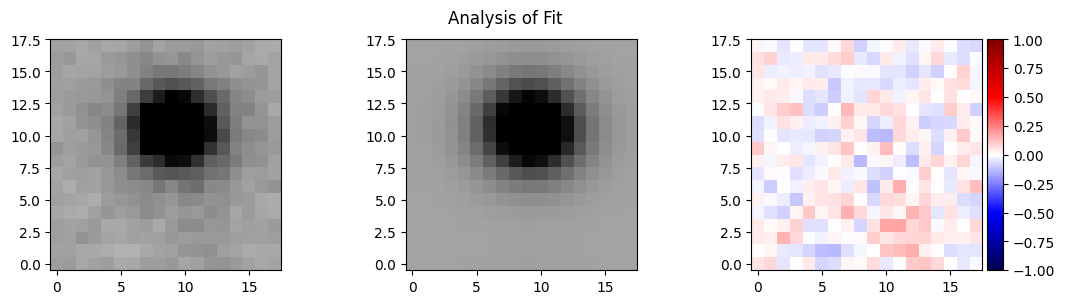

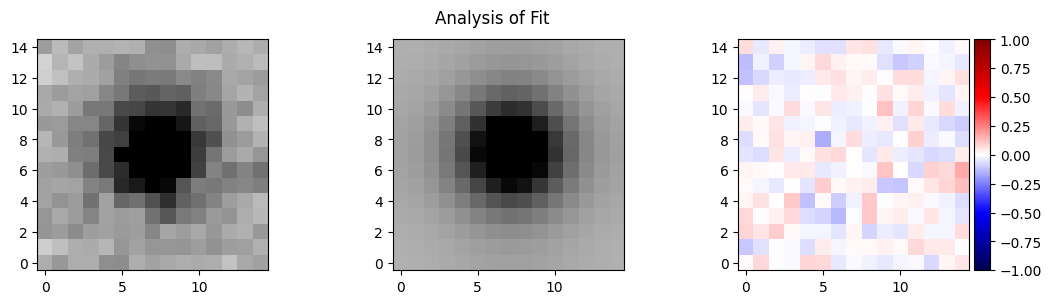

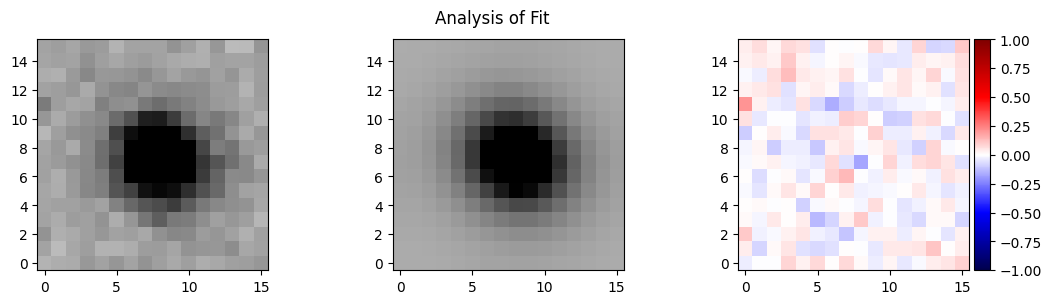

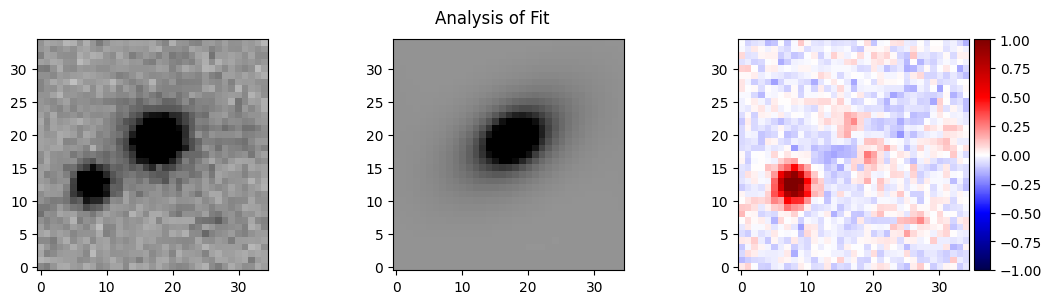

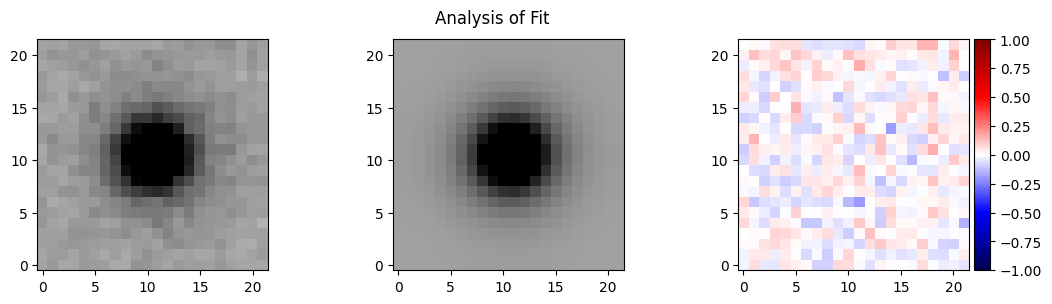

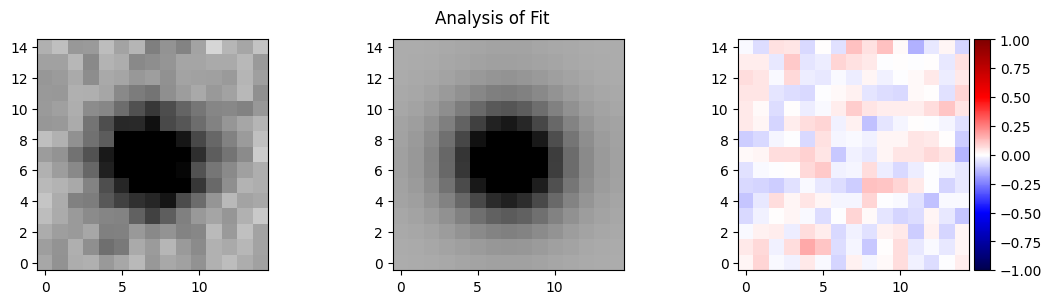

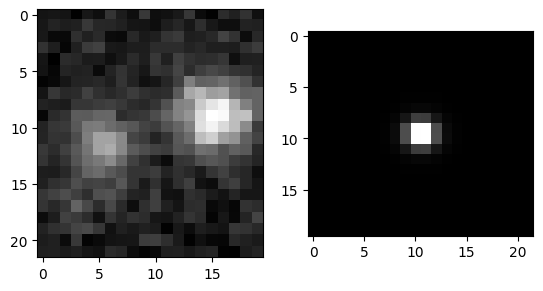

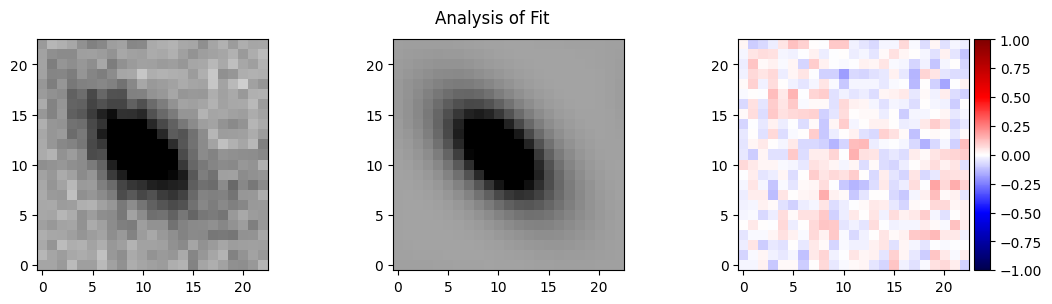

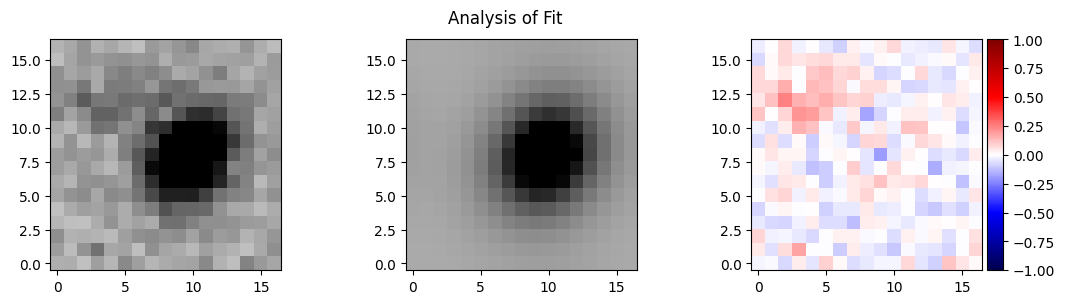

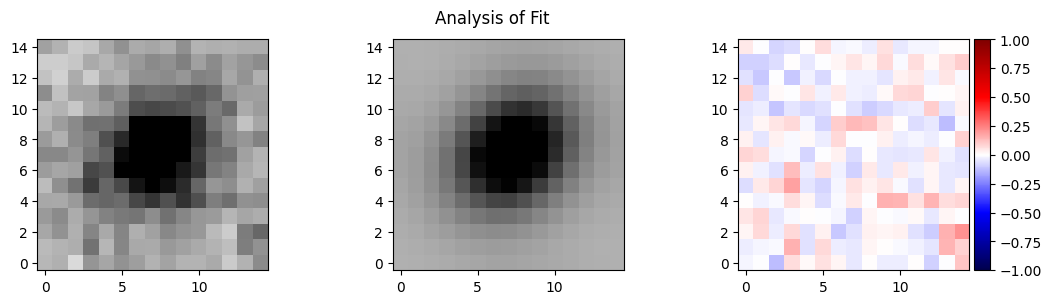

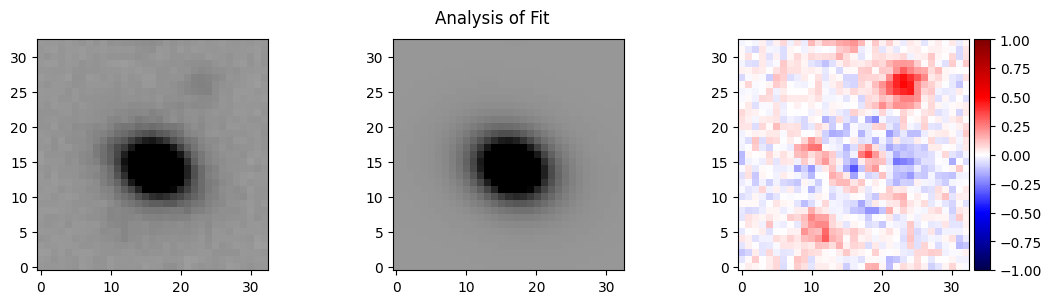

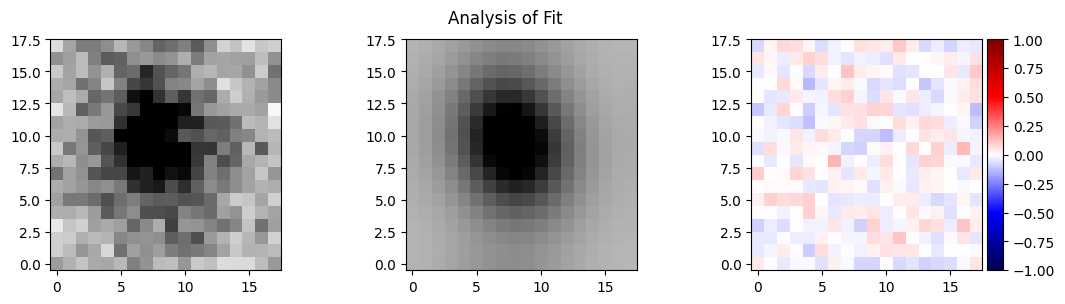

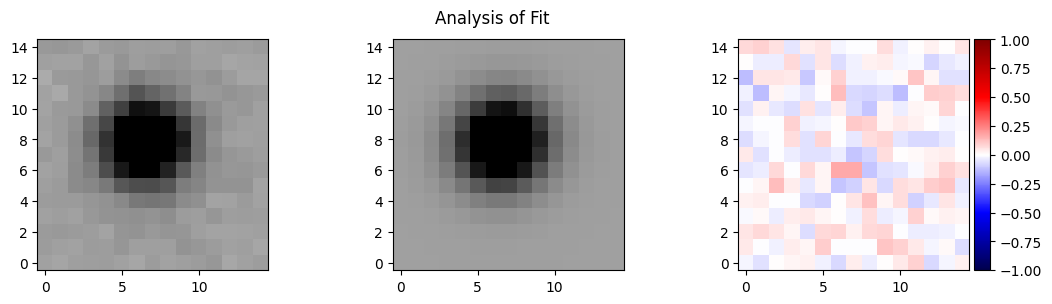

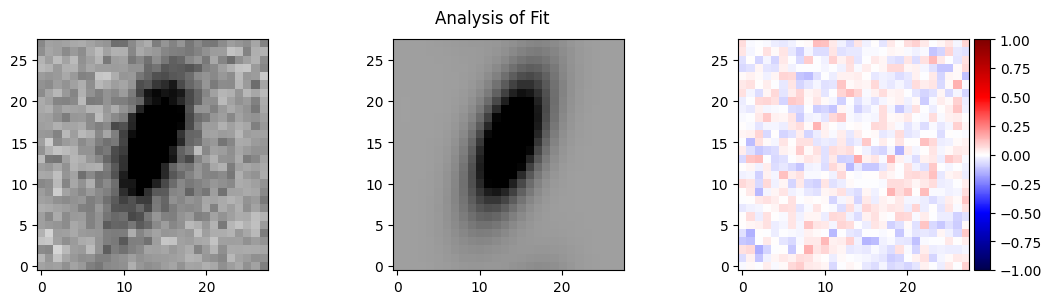

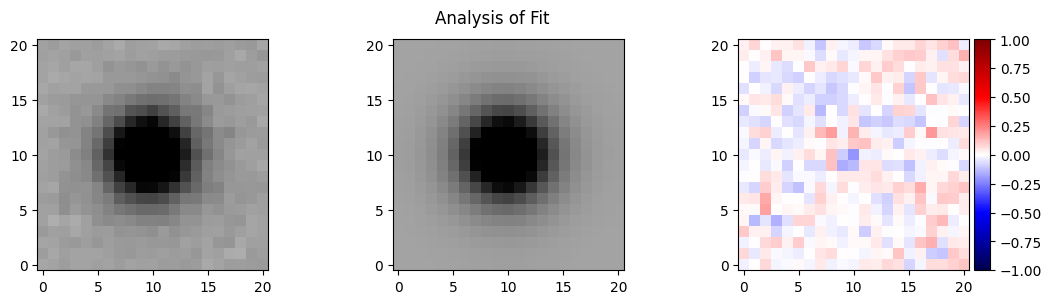

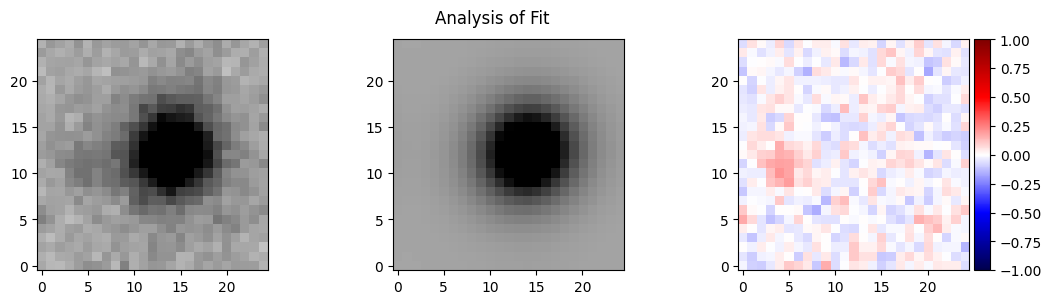

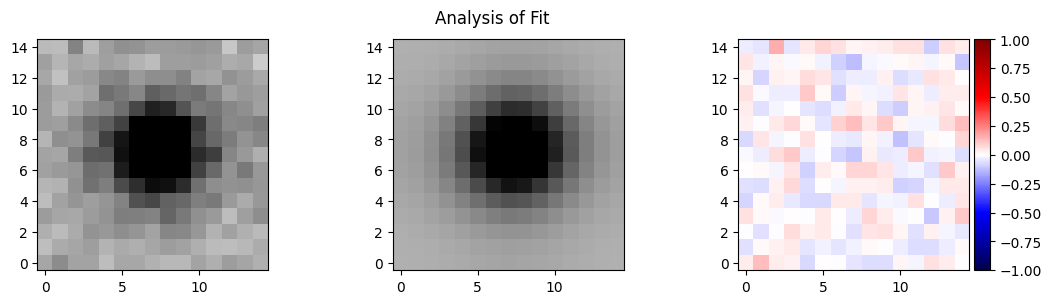

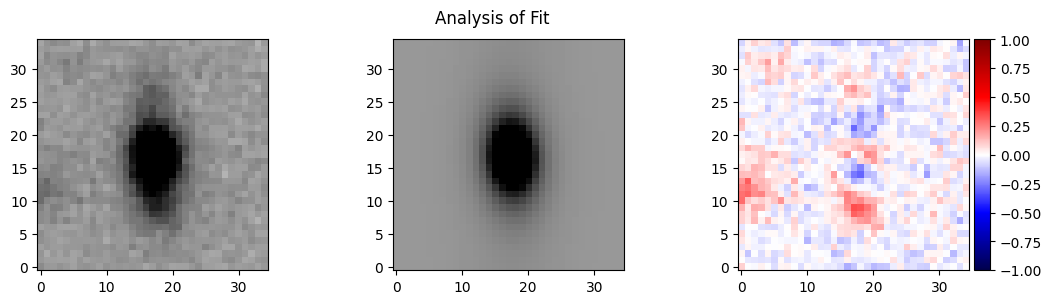

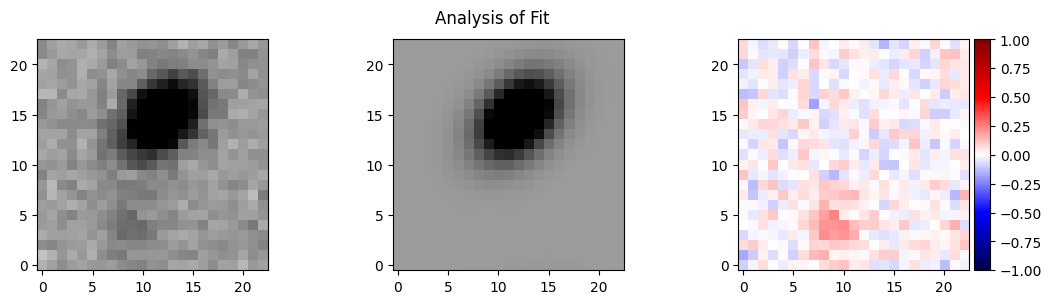

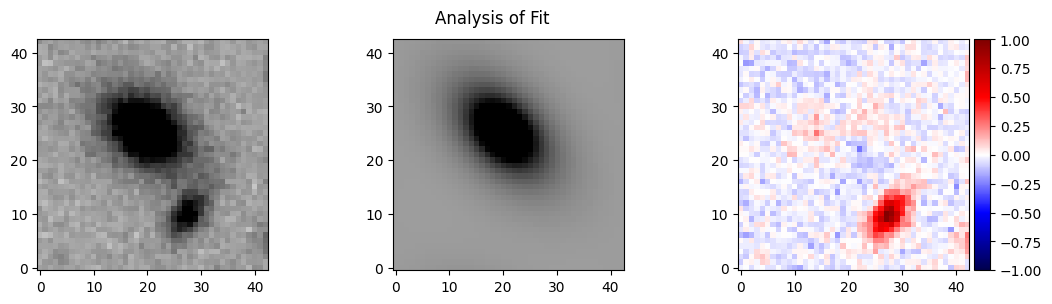

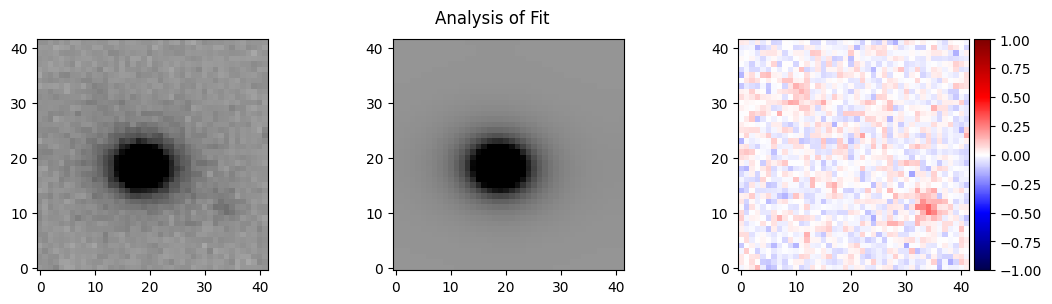

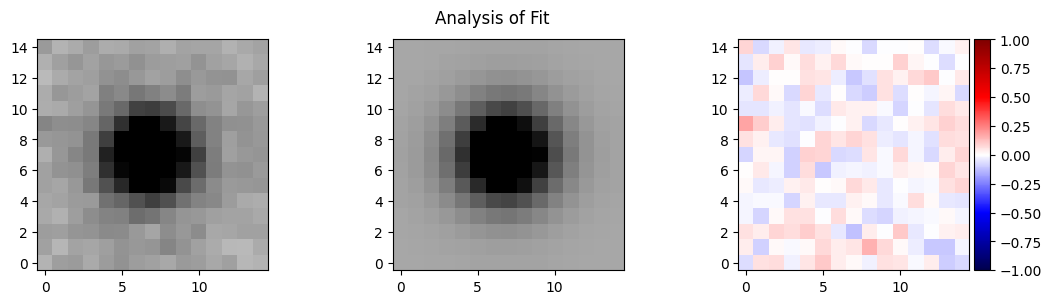

In [113]:
##############################################
# Fitting a Sersic Profile ------------------#
##############################################

from pysersic import FitSingle
from pysersic.loss import student_t_loss
from pysersic import results
from pysersic.priors import autoprior
from pysersic.priors import SourceProperties
from pysersic import check_input_data
from pysersic import FitSingle
from pysersic.loss import gaussian_loss
from pysersic.results import plot_residual

# future --> test different loss functions --> student-t-loss, gaussian
good_list = []
bad_list = []

for i in range(13,len(cutouts),2):
    
    im,mask,sig,psf = cutouts[i] # image, mask, variance, psf
    if (im.shape[0] != psf.shape[0] or im.shape[1] != psf.shape[1]):
        fig, axes = plt.subplots(1,2)
        axes[0].imshow(im.data,cmap="gray")
        axes[1].imshow(psf,cmap='gray')
        
    else:
        # Plotting Cutout & PSF
        # fig, axes = plt.subplots(1, 1, figsize=(12, 12))
        #     axes[0].imshow(im.data, cmap='gray', origin="lower")
        #     axes[0].set_title('Cutout')
        #     axes[0].axis('off')
        #     plt.show()

        # Verify Components are Usable
        check_input_data(im.data, sig.data, psf, mask)

        # Prior Estimation of Parameters
        props = SourceProperties(im.data,mask=mask) 
        prior = props.generate_prior('sersic',sky_type='none')

        # Fit
        fitter = FitSingle(data=im.data,rms=sig.data, psf=psf, prior=prior, mask=mask, loss_func=gaussian_loss) 
        map_params = fitter.find_MAP(rkey = PRNGKey(1000));               # contains dictionary of Sersic values
        fig, ax = plot_residual(im.data,map_params['model'],mask=mask,vmin=-1,vmax=1);
        fig.suptitle("Analysis of Fit")

        ##############################################
        # Testing Fit -------------------------------#
        # (does it belong in training dataset)
        ##############################################
        image = im.data
        model = map_params['model']
        assert(image.shape == model.shape)

        # Chi-squared Statistic ----------------------------------------------------------------#
        # (evaluating whether the difference in Image and Model is systematic or due to noise)

        from scipy.stats import chi2
        chi_square = np.sum((image*2.2 - model) ** 2 / (model))
        df = image.size-1                                                 # number of categories - 1
        p_value = chi2.sf(chi_square, df)
        noise_threshold = np.mean(sig.data)                               # average of the variance
        
        image_1D = image.flatten()
        model_1D = model.flatten()
        difference_1D = image_1D - model_1D
        l1 = np.sum(np.abs(difference_1D))
        l1_normalized = l1/(image_1D.size)
        print(f"L1 norm: {l1_normalized}")
        
        if (p_value < noise_threshold):
            print(f"This model is not good.{p_value}")
            bad_list.append([image,model,p_value,l1_normalized])
        else:
            print(f"This model is a good fit.{p_value}")
            good_list.append([im.data,model,p_value,l1_normalized])

        # L1-Norm Statistic/Manhatten Distance (1) ---------------------------------------------#
        # (sum of absolute value of (actual pixel value - model pixel value) for all pixels)

        # what threshold should the l1_normalized metric meet?


/tmp/ipykernel_193996/2456432049.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,3)


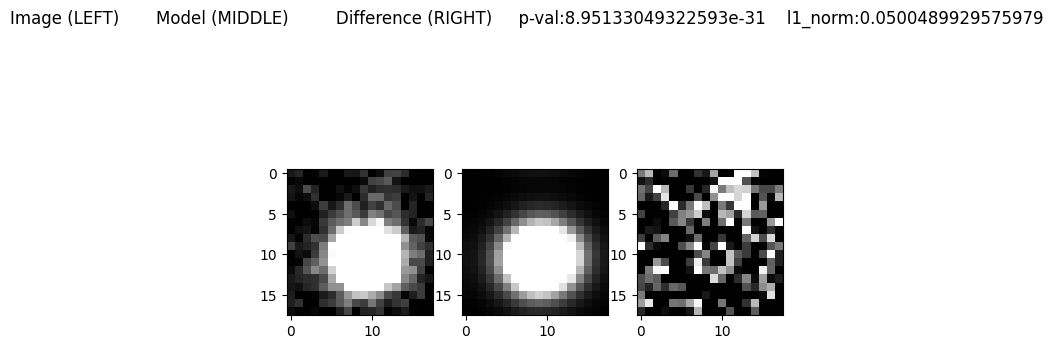

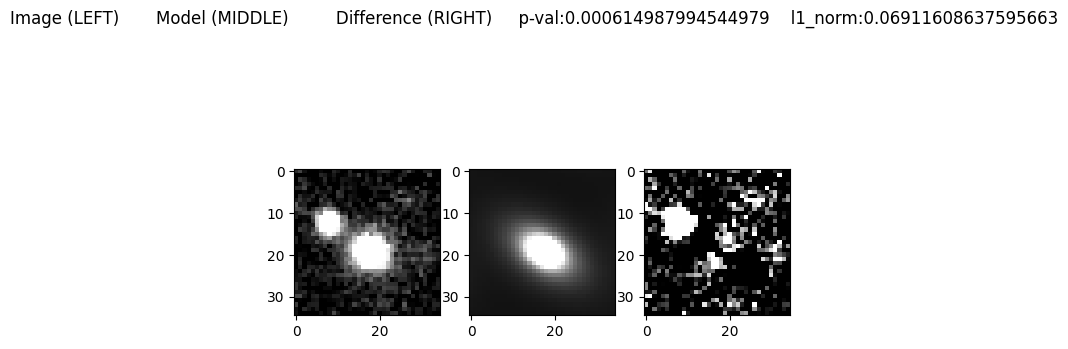

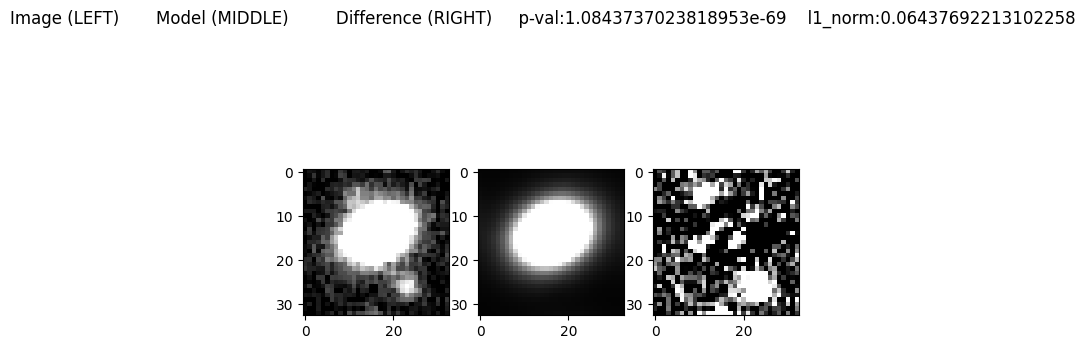

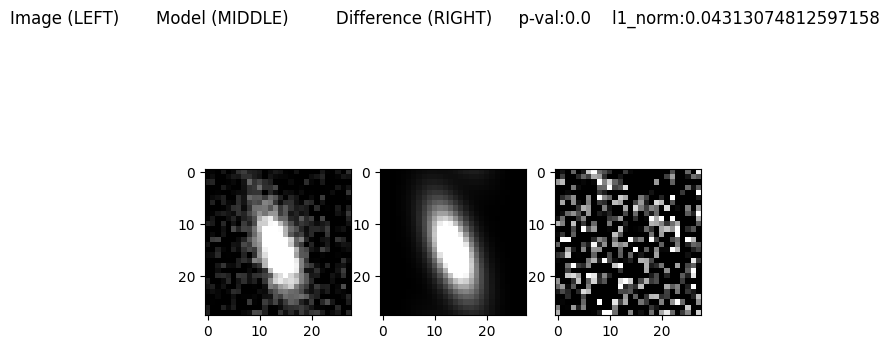

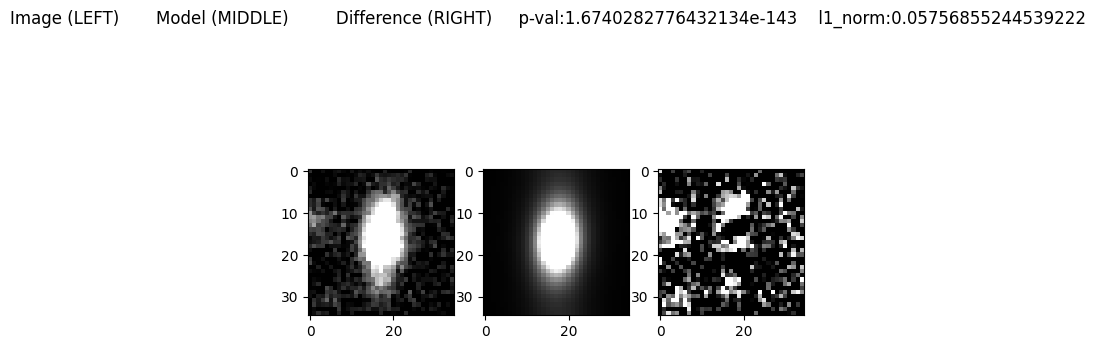

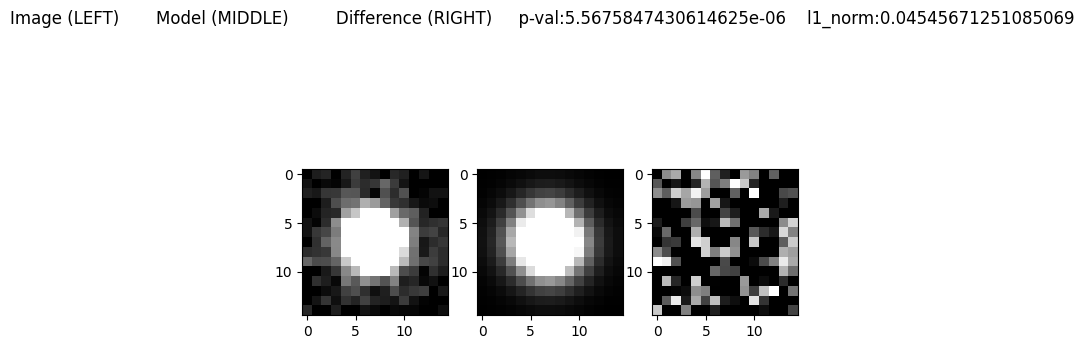

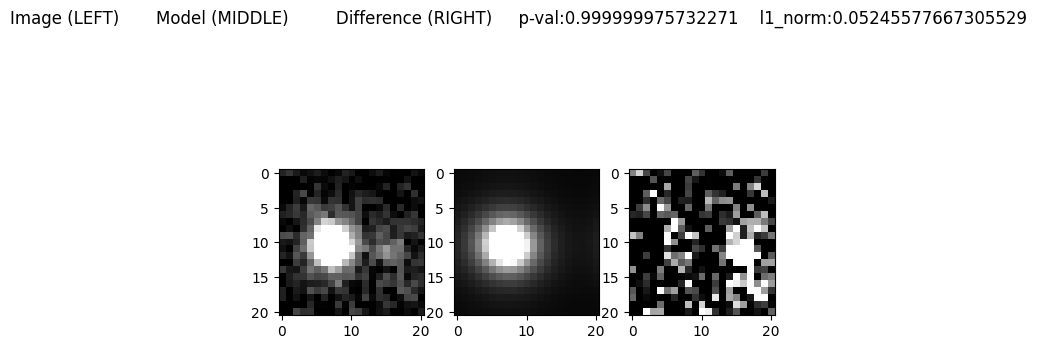

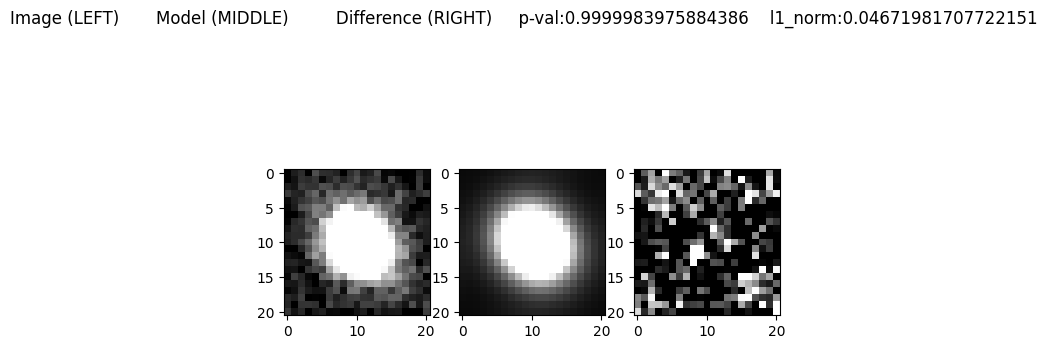

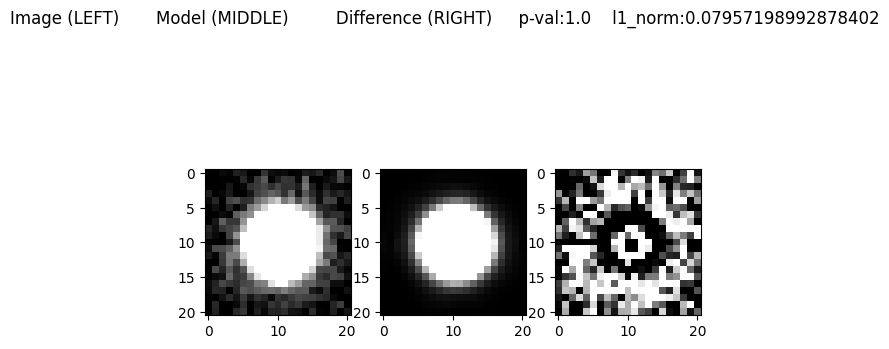

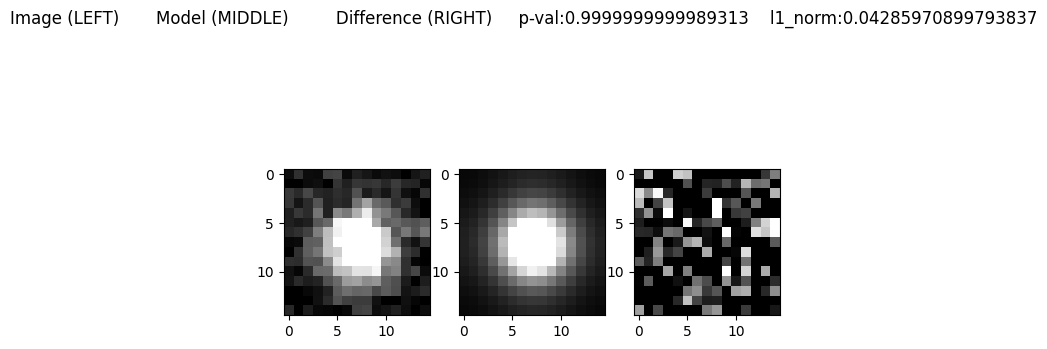

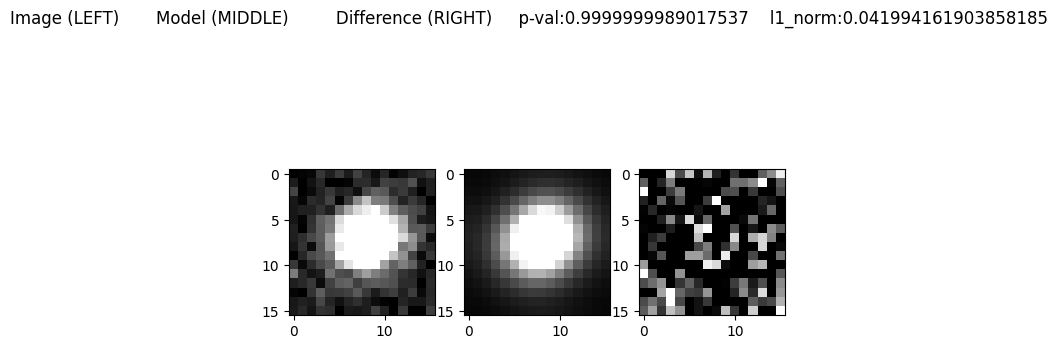

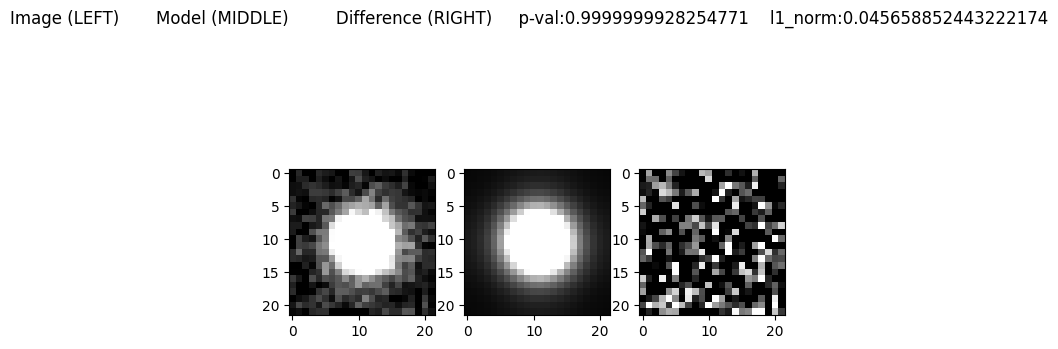

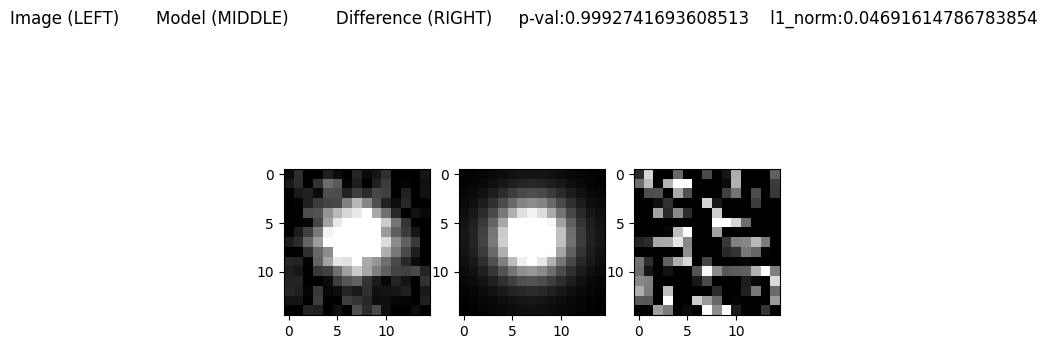

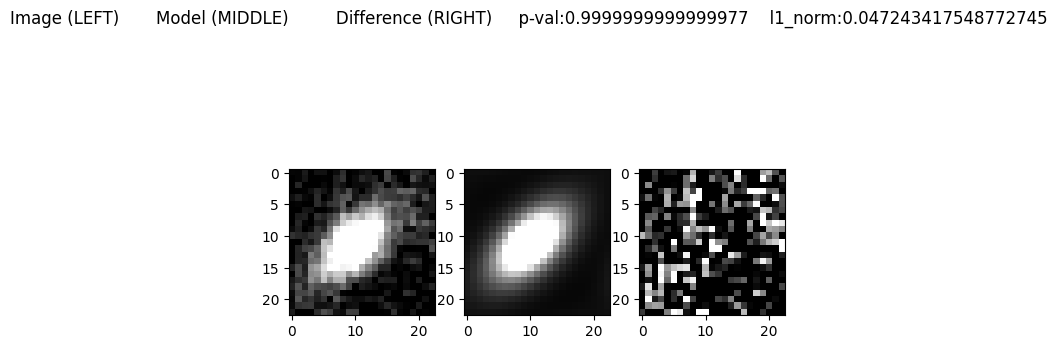

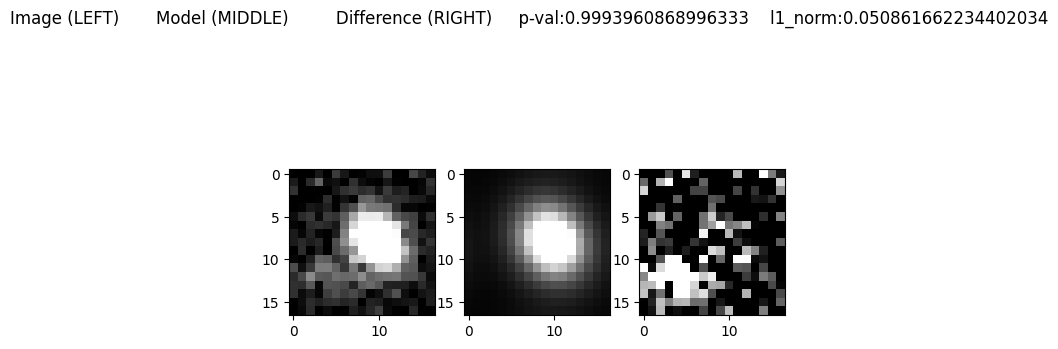

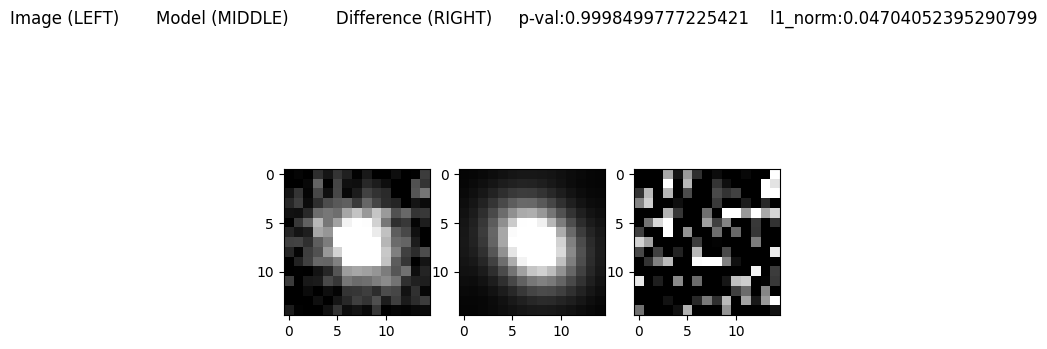

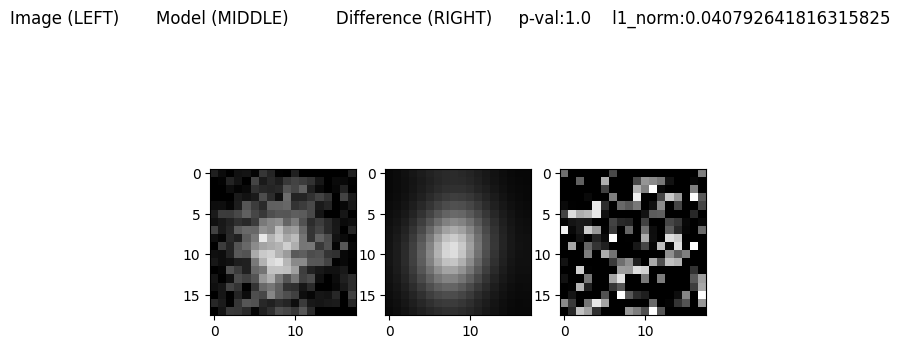

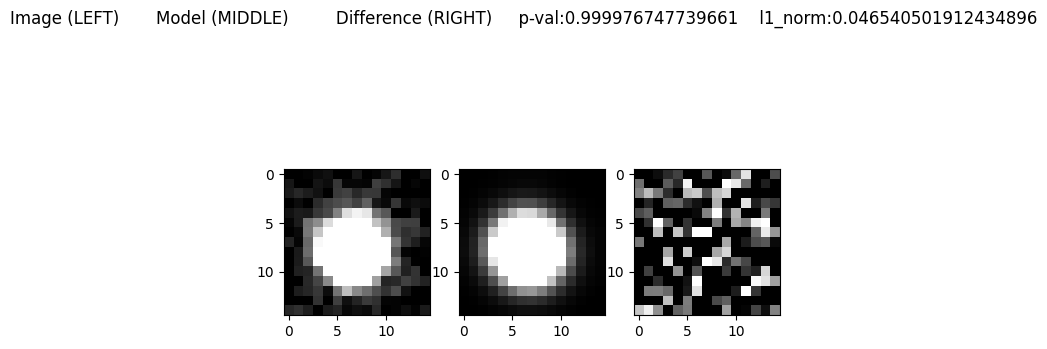

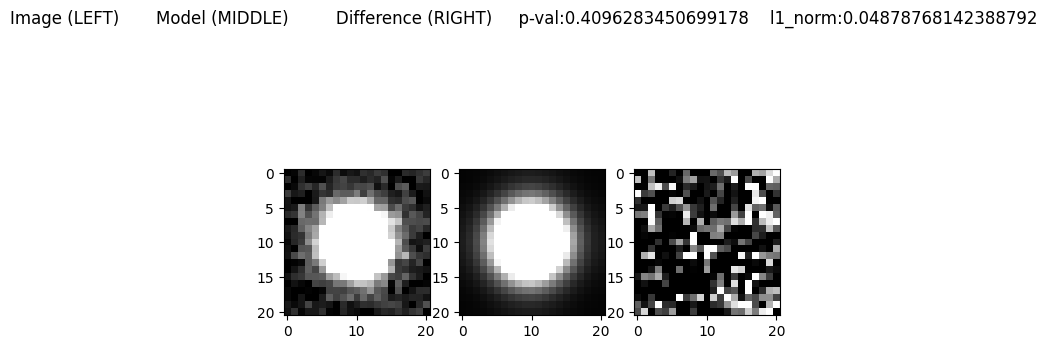

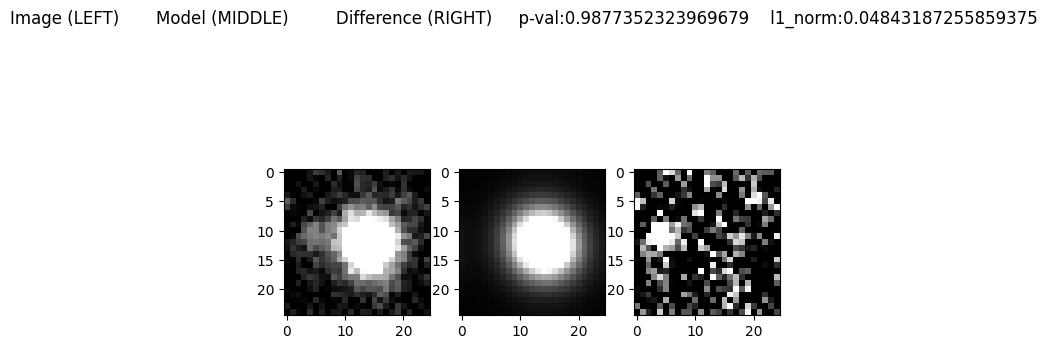

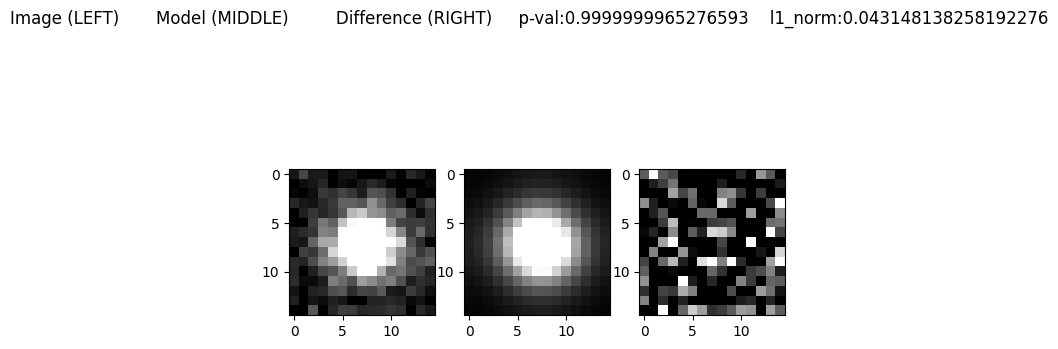

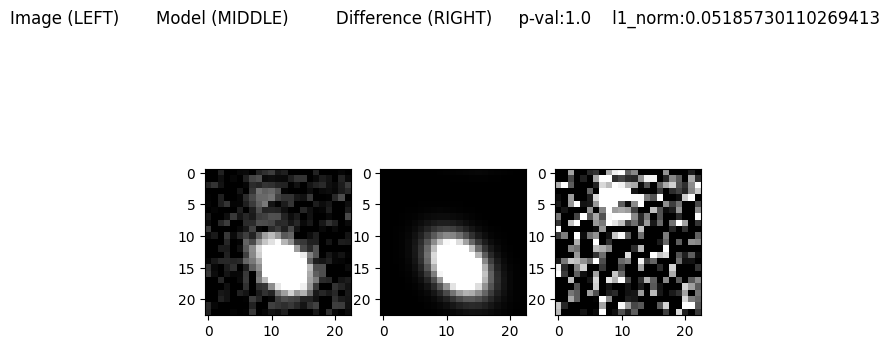

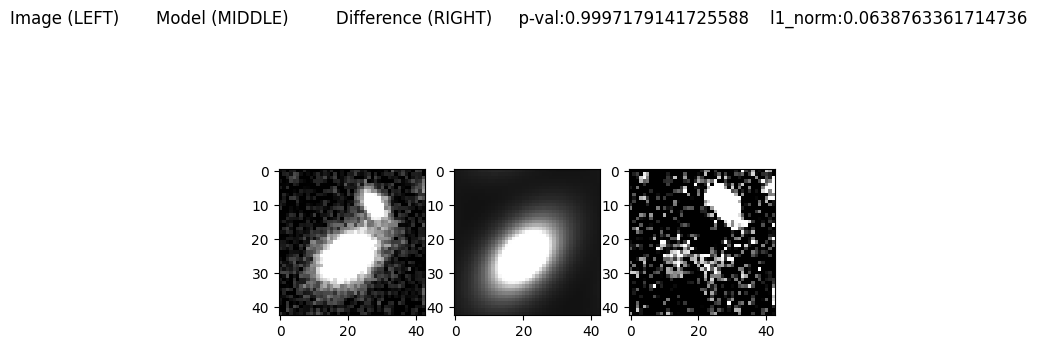

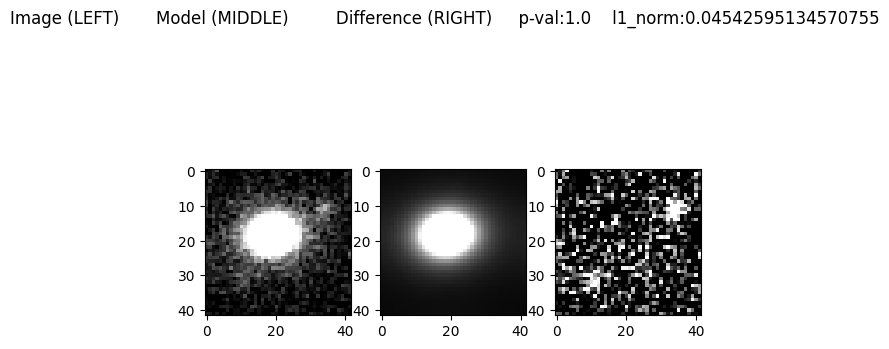

In [114]:
for i in bad_list:
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(i[0],cmap="gray", vmin=0, vmax=0.5)
    axes[1].imshow(i[1],cmap="gray", vmin=0, vmax=0.5)
    axes[2].imshow(i[0]-i[1],cmap="gray",vmin=0, vmax=0.1)

    fig.suptitle(f"Image (LEFT)       Model (MIDDLE)         Difference (RIGHT)     p-val:{i[2]}    l1_norm:{i[3]}")
for i in good_list:
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(i[0],cmap="gray", vmin=0, vmax=0.5)
    axes[1].imshow(i[1],cmap="gray", vmin=0, vmax=0.5)
    axes[2].imshow(i[0]-i[1],cmap="gray",vmin=0, vmax=0.1)

    fig.suptitle(f"Image (LEFT)       Model (MIDDLE)         Difference (RIGHT)     p-val:{i[2]}    l1_norm:{i[3]}")

In [90]:
"""
Sources:
1) https://medium.com/swlh/different-types-of-distances-used-in-machine-learning-ec7087616442#:~:text=L1%20Norm%3A,the%20components%20of%20the%20vectors.

"""

'\nSources:\n1) https://medium.com/swlh/different-types-of-distances-used-in-machine-learning-ec7087616442#:~:text=L1%20Norm%3A,the%20components%20of%20the%20vectors.\n\n'